# Explaining Outcomes from Black Box Models

This notebook demonstrates how SLISE can be used to explain outcomes from black box models.

The way SLISE explains outcomes is based upon locally approximating the complex model with a simpler one.
This is not a new idea, see, e.g., [LIME](https://github.com/marcotcr/lime) and [SHAP](https://github.com/slundberg/shap). What SLISE does different is that we don't create any new (potentially unrealistic) data, and instead use existing data and predictions. The way we accomplish this is by fitting a (sparse) linear model that suits the item being explained, and a subset (/neighbourhood) of items with a bounded error. See the [paper](https://rdcu.be/bVbda) for full details.

## Prerequisites

The example in this notebook assumes that SLISE is installed, which can be done with:
```sh
pip install https://github.com/edahelsinki/pyslise
```
We also need Keras (Tensorflow) for the neural network:

In [1]:
import numpy as np
from tensorflow import keras
import slise
from matplotlib import pyplot as plt

## Dataset

The dataset is the boston housing dataset with 13 variables where the task is to predict the median value of homes in different areas.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(seed=42)
variables = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

The meaning of the variables are:

| Variable | Description |
|----------|-------------|
| CRIM     | per capita crime rate by town |
| ZN       | proportion of residential land zoned for lots over 25,000 sq.ft. |
| INDUS    | proportion of non-retail business acres per town |
| CHAS     | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| NOX      | nitric oxides concentration (parts per 10 million) |
| RM       | average number of rooms per dwelling |
| AGE      | proportion of owner-occupied units built prior to 1940 |
| DIS      | weighted distances to five Boston employment centres |
| RAD      | index of accessibility to radial highways |
| TAX      | full-value property-tax rate per $10,000 |
| PTRATIO  | pupil-teacher ratio by town |
| B        | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| LSTAT    | % lower status of the population |

The response is the median value of owner-occupied homes in $1000's.

## Model

As the black box model we use a simple neural network with three hidden layers, ReLU activations, batch normalisation, and dropout.

In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=13),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [4]:
model.compile(loss = "mean_squared_error", optimizer="adam")
model.fit(x_train, y_train, batch_size=64, epochs=16, validation_split=0.1)
print("Test loss:", model.evaluate(x_test, y_test))

Epoch 1/16
6/6 [==============================] - 0s 22ms/step - loss: 567.7059 - val_loss: 568.0767
Epoch 2/16
6/6 [==============================] - 0s 3ms/step - loss: 520.2480 - val_loss: 575.4934
Epoch 3/16
6/6 [==============================] - 0s 3ms/step - loss: 482.2212 - val_loss: 572.2572
Epoch 4/16
6/6 [==============================] - 0s 3ms/step - loss: 448.5967 - val_loss: 562.9951
Epoch 5/16
6/6 [==============================] - 0s 3ms/step - loss: 413.5609 - val_loss: 551.7427
Epoch 6/16
6/6 [==============================] - 0s 3ms/step - loss: 389.1068 - val_loss: 541.1149
Epoch 7/16
6/6 [==============================] - 0s 2ms/step - loss: 353.1598 - val_loss: 531.1224
Epoch 8/16
6/6 [==============================] - 0s 3ms/step - loss: 320.4051 - val_loss: 522.1226
Epoch 9/16
6/6 [==============================] - 0s 3ms/step - loss: 287.4419 - val_loss: 511.7709
Epoch 10/16
6/6 [==============================] - 0s 3ms/step - loss: 261.4268 - val_loss: 500.105

## Explanation

The variables have widely different magnitudes (e.g. \[0,1\] and \[100, 700\]) and since the magnitude of the linear model coefficients are inversely correlated to the variable magnitude this can cause issues for the (sparsity) regularisation. That's why we use SLISE with normalisation. It is also easier to judge the "importance" of different variables if the they have the same scales.

In [5]:
item = 1
x = x_test[item]
y = model.predict(x_test)[item]
p_train = model.predict(x_train).ravel()
explanation = slise.explain(x_train, p_train, 0.4, x, y, lambda1=1, normalise=True)
print("Neighbourhood size:", explanation.subset().mean())

Neighbourhood size: 0.5297029702970297


One of the big advantages of SLISE is that it not only considers the model, but also the dataset. Thus, it can be interesting to compare the explained item to the rest of the dataset. To further this investigation we also plot the variable distributions of the dataset, and mark the explained item.

The approximating linear model (normalised or unnormalised) tells us how we can "modify" the explained item to increase or decrese the prediction.

Furthermore, we have the concept of "impact", which is the explained item times the approximating model. This allows us to manually reconstruct the prediction by summing together the impacts (which helps us understand the linear model). 

The normalised impact includes a comparison to the rest of the dataset. If the model coefficient is positive but variable value is less than expected (median) then the impact will also be less than expected. The normalised impact represents this "less than expected impact" as a negative impact (and vice versa for negative coefficients).

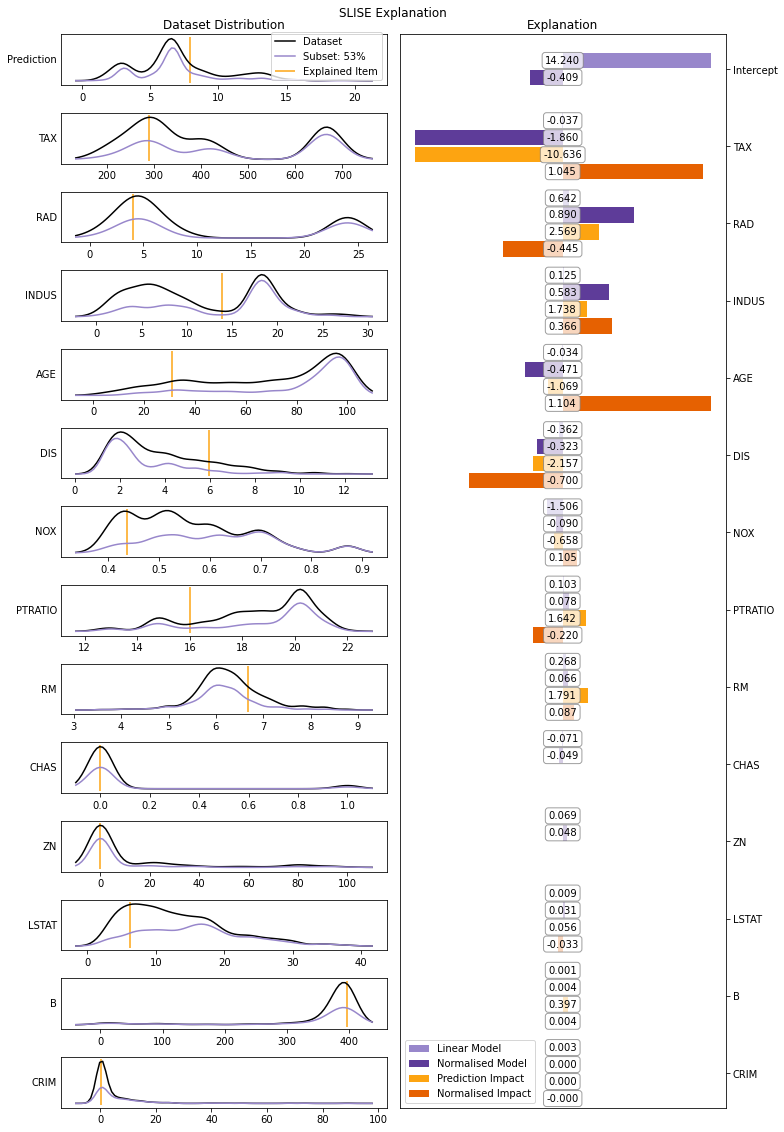

In [6]:
explanation.plot_dist(variables=variables, fig=plt.figure(figsize=(11, 16)))
plt.show()

The location we are investigating is predicted to have a medium home value. The prediction is positively impacted by the availability of jobs (INDUS), how new the houses are (AGE), and the relatively low property tax (TAX). The main downsides are how far the location is from any city centre (DIS) and how poor the connections are (RAD).

Notice how the interpretation of the explanation is not only hinged on the local approximation but also how it interacts with the data (primarily the data item we are explaining). The locally approximating linear model tells us how the variables affect the prediction, but we have to combine it with data (impact) to understand the given outcome.